In [1]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

check_gpu = len(tf.config.list_physical_devices('GPU'))>0

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if check_gpu \
      else "NOT AVAILABLE")

Tensor Flow Version: 2.12.0
Keras Version: 2.12.0

Python 3.10.9 (main, Jan 11 2023, 09:18:18) [Clang 14.0.6 ]
Pandas 1.5.3
Scikit-Learn 1.2.2
GPU is available


In [2]:
!pip install fastseg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.2 MB/s eta 0:00:00


In [3]:
!pip install fastai --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.1/233.1 kB 4.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 479.3 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.4/778.4 kB 2.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.3/490.3 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.0 MB/s eta 0:00:00-:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 1.3 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 1.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 433.0 kB/s eta 0:00:00a 0:00:01


In [4]:
import albumentations  as albu
albu.__version__

'1.3.0'

In [5]:
from fastai.vision.all import *

In [6]:
import os
import matplotlib.pyplot as plt
import cv2
def get_image_array_from_fn(fn):
    image = cv2.imread(fn)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Path 


In [7]:
DATA_DIR = "/Users/sathvikchowdaryveerapaneni/Desktop/CV/Deep_Learning_Project/Lane-Segmmentation-using-Deep-Learning/Data"

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_label')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_label')

fastai library

In [8]:
# function that takes filename of a training image 'fn' and returns the filename of the corresponding label image
def label_func(fn): 
    return str(fn).replace(".png", "_label.png").replace("train", "train_label").replace("val/", "val_label/")

/Users/sathvikchowdaryveerapaneni/Desktop/CV/Deep_Learning_Project/Lane-Segmmentation-using-Deep-Learning/Data/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2490.png


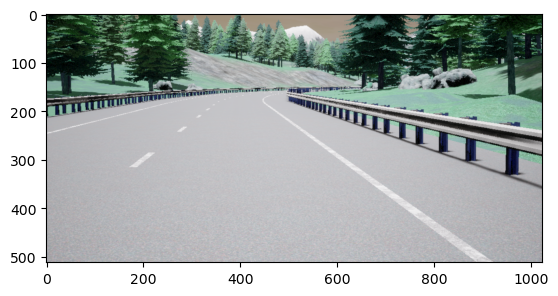

In [9]:
# pick the first image from the training directory and show it
sample_fn = x_train_dir + "/" + os.listdir(x_train_dir)[0]
print(sample_fn)
plt.imshow(get_image_array_from_fn(sample_fn));

/Users/sathvikchowdaryveerapaneni/Desktop/CV/Deep_Learning_Project/Lane-Segmmentation-using-Deep-Learning/Data/train_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2490_label.png


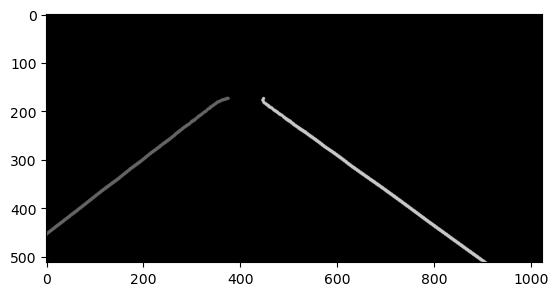

In [10]:
# get corresponding label image using our 'label_func' function
label_fn = label_func(sample_fn)
print(label_fn)
# we multiply the image intensity by 100 to make lane lines visible for the human eye:
plt.imshow(100*get_image_array_from_fn(label_fn)); 

In [12]:
#get_image_files
my_get_image_files = partial(get_image_files, folders=["train", "val"])

In [13]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    

albu_transform_list = [
    albu.IAAAdditiveGaussianNoise(p=0.2),
    albu.OneOf(
        [
            albu.CLAHE(p=1),
            albu.RandomBrightness(p=1),
            albu.RandomGamma(p=1),
        ],
        p=0.6,
    ),
    albu.OneOf(
        [
            albu.IAASharpen(p=1),
            albu.Blur(blur_limit=3, p=1),
            albu.MotionBlur(blur_limit=3, p=1),
        ],
        p=0.6,
    ),
    albu.OneOf(
        [
            albu.RandomContrast(p=1),
            albu.HueSaturationValue(p=1),
        ],
        p=0.6,
    ),
]
albu_transform = albu.Compose(albu_transform_list)

/Users/sathvikchowdaryveerapaneni/miniconda3/envs/tensorflow/lib/python3.10/site-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/Users/sathvikchowdaryveerapaneni/miniconda3/envs/tensorflow/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/Users/sathvikchowdaryveerapaneni/miniconda3/envs/tensorflow/lib/python3.10/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/Users/sathvikchowdaryveerapaneni/miniconda3/envs/tensorflow/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: R

In [14]:
codes = np.array(['back', 'left','right'],dtype=str)

In [15]:
carla = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items = my_get_image_files,
                   get_y = label_func,
                   splitter = FuncSplitter(lambda x: str(x).find('validation_set')!=-1),
                   item_tfms=[SegmentationAlbumentationsTransform(albu_transform)])

In [16]:
dls = carla.dataloaders(Path(DATA_DIR), path=Path("."), bs=2)

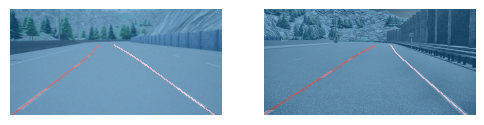

In [17]:
dls.show_batch(max_n=6)


In [18]:
from fastseg import MobileV3Small

model = MobileV3Small(num_classes=3, use_aspp=True, num_filters=8)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_small_100-37f49e2b.pth" to /Users/sathvikchowdaryveerapaneni/.cache/torch/hub/checkpoints/tf_mobilenetv3_small_100-37f49e2b.pth


In [19]:
learn = Learner(dls, model, metrics=[DiceMulti()])

In [20]:
learn.fine_tune(5)

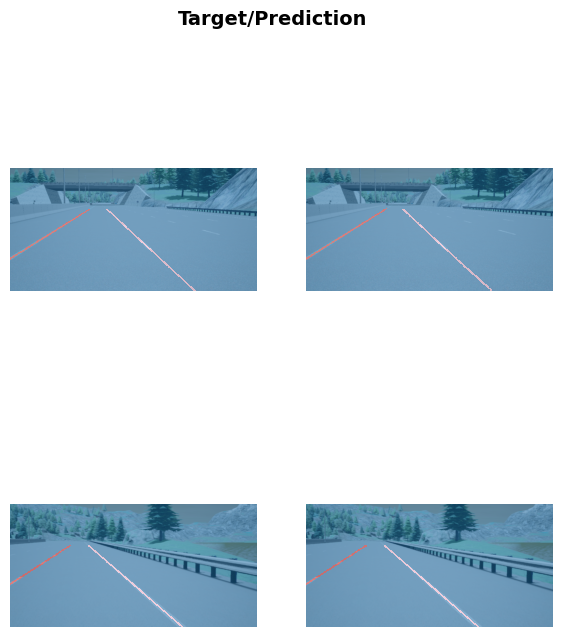

In [21]:
learn.show_results(max_n=6, figsize=(7,8))

In [22]:
torch.save(learn.model, './fastai_model.pth')

Experiments


In [116]:
import cv2
img = cv2.imread(str(get_image_files(x_valid_dir)[5]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

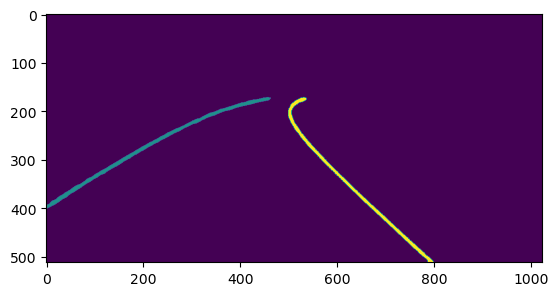

In [122]:
plt.imshow(np.array(learn.predict(img)[0]))


In [104]:
def get_pred_for_mobilenet(model, img_array):
    with torch.no_grad():
        image_tensor = img_array.transpose(2,0,1).astype('float32')/255
        x_tensor = torch.from_numpy(image_tensor).to("mps").unsqueeze(0)
        model_output = F.softmax( model.forward(x_tensor), dim=1 ).cpu().numpy()
    return model_output

In [105]:
learn.model.eval();

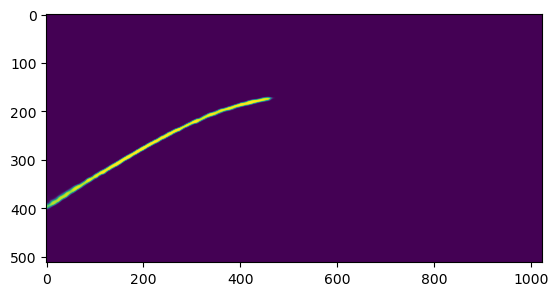

In [125]:
# With Chaging the models from 1 and 2 we are getting the left and right lanes
plt.imshow(get_pred_for_mobilenet(learn.model,img)[0][1])

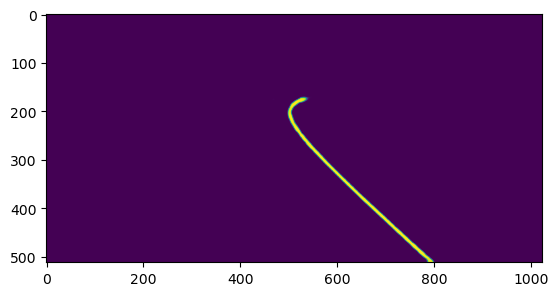

In [126]:
plt.imshow(get_pred_for_mobilenet(learn.model,img)[0][2])

In [107]:
%timeit get_pred_for_mobilenet(learn.model,img)

42.2 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


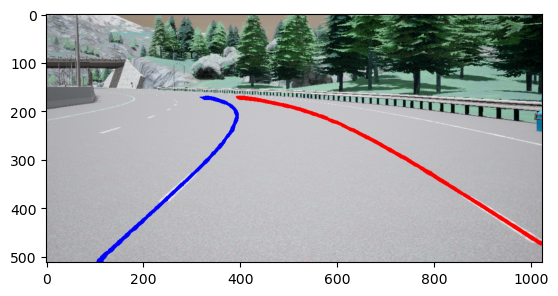

In [110]:
import copy
back, left, right = get_pred_for_mobilenet(learn.model,img)[0]
def ld_detection_overlay(image, left_mask, right_mask):
    res = copy.copy(image)
    res[left_mask > 0.3, :] = [0,0,255]
    res[right_mask > 0.3, :] = [255,0,0]
    return res
plt.imshow(ld_detection_overlay(img, left, right))